In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy
from torch import nn
import torch
from torch.utils.data import Dataset

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

# L05

In this notebook I will experiment with how to significantly speed up the simulation time for the Kuramoto-Sivashinsky (KS) equation. I will be doing this trough reduced order modeling (ROM) and i will experiment with a few different ways of interpolating the non-linear terms.

## E 12.2

In order to do reduced order modeling I here generate a high fidelity solution to the KS equation. I use the FFT-derivative method to find the derivatives $u_x, u_{xx}$ and $u_{xxxx}$ in the equation below. I use an initial condition of $u(x,0)=sech(x)$.

The equation I will be using is:
$$ u_t + u_{xx} + u_{xxxx} + \frac{1}{2}u_x^2 = 0 $$

Solve time: 75.2035779953003


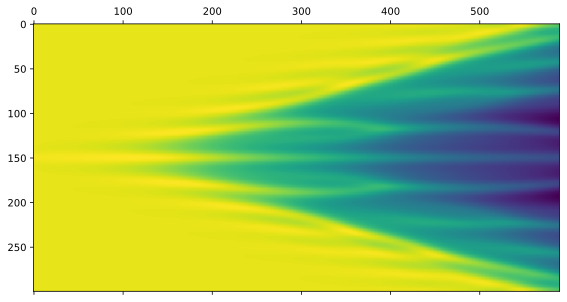

In [3]:
# t_span = (0,50)
# simulation_width = 35
# simulation_points = 100

# t_span = (0,30)
# simulation_width = 50
# simulation_points = 3*simulation_width

# t_span = (0,40)
# simulation_width = 100
# simulation_points = 3*simulation_width

t_span = (0,50)
simulation_width = 100
simulation_points = 3*simulation_width


xs = np.linspace(-simulation_width,simulation_width, num=simulation_points)
u0 = (np.cosh(xs))**(-1)

kappa = (np.pi*2/simulation_width)*np.arange(-simulation_points/2,simulation_points/2)
kappa = np.fft.fftshift(kappa)

def rhs_ks(t,u,kappa):
    u_hat = np.fft.fft(u)
    d_u_hat = (1j*kappa)*u_hat
    d_2u_hat = ((1j*kappa)**2)*u_hat
    d_4u_hat = ((1j*kappa)**4)*u_hat

    d_u = np.real(np.fft.ifft(d_u_hat))
    d2_u = np.real(np.fft.ifft(d_2u_hat))
    d4_u = np.real(np.fft.ifft(d_4u_hat))

    return -d2_u - d4_u - (1/2)*(d_u**2)

t_full_start = time.time()
sol = scipy.integrate.solve_ivp(rhs_ks, t_span=t_span, y0=u0, args=(kappa,))
t_full_stop = time.time()

print(f"Solve time: {t_full_stop - t_full_start}")

t_simulation = sol.t
y_simulation = sol.y

plt.matshow(y_simulation[:,::200])


The above plot shows the high fidelity solution to the KS equation. The goal of the next couple of experiments will be to model this equation in a smaller subspace in order to speed up simulation time.

### SVD analysis

I will be using the POD method to find a reduced subspace. I therefore need to find how many SVD modes I need to use in order to capture the most variance in the model while reducing the number of dimensions.

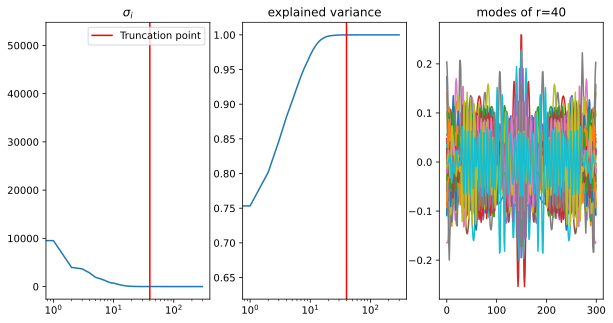

In [4]:
U, sigma, Vt = np.linalg.svd(y_simulation, full_matrices=False)


r = 40
Psi = U[:,0:r]
W = (np.diag(sigma)[0:r,0:r]) @ Vt[0:r,:]


fig, axs = plt.subplots(1,3, figsize=(10,5))

axs[0].set_title(r"$\sigma_i$")
axs[0].semilogx(sigma)

axs[0].axvline(x=r, label="Truncation point", color="red")
axs[0].legend()

axs[1].set_title(r"explained variance")
axs[1].semilogx((np.cumsum(sigma) / np.sum(sigma)))


axs[1].axvline(x=r, label="Truncation point", color="red")

axs[2].set_title(f"modes of r={r}")
for i in range(r):
    axs[2].plot(U[:,i])


These plots shows the singular values and the explained variance for every cut-off point. I chose to have the truncation at r=40 since this gave nice results.

## DMD

A simple linear DMD model can now be made in order to try and predict the next snapshot based on the current. Each snapshot of the high fidelity solution is projected onto the first r=40  SVD-modes calculated above. Next I solve the following system:

$$ W' = A W $$

Where the columns of W are the projected snapshots of the high fidelity solution. W' is a matrix that leaves out the first snapshot. The matrix A will be the solution that best maps W to W' or each snapshot to the next (In a L2 norm sense).


Text(0.5, 1.0, 'DMD rom')

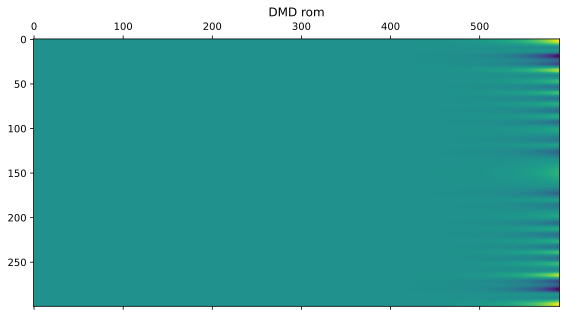

In [5]:
U_dmd, sigma_dmd, Vt_dmd = np.linalg.svd(y_simulation, full_matrices=False)
W_dmd = np.diag(sigma[0:r]) @ Vt_dmd[0:r,:]
A_dmd = W_dmd[:,1:] @ np.linalg.pinv(W_dmd[:,:-1])

y_dmd = np.array([ U_dmd[:,0:r] @ (np.power(A_dmd,i+1) @ W_dmd[:,0]) for i in range(W_dmd.shape[1]) ]).T
plt.matshow(y_dmd[:,::200])
plt.title("DMD rom")

The result above clearly shows that a DMD model is not applicable to create a ROM for the nonlinear system.

## Galerkin-POD approximation

To solve the system a Galerkin-POD approximation can be used:
$$ u_t = L u + N(u, u_x, u_{xx},..., \beta) $$
Where
$$ u(t) \approx \Phi a(t) $$

This gives:
$$a'(t) = \Phi^T L \Phi a(t) + \Phi^T N(\Phi a(t), \beta )  $$

The lienar term is computed below:

In [6]:
d2_Psi_hat = ((1j*kappa[:,np.newaxis])**2)*np.fft.fft(Psi, axis=0)
d4_Psi_hat = ((1j*kappa[:,np.newaxis])**4)*np.fft.fft(Psi, axis=0)

Psi_L = Psi.T @ (-np.real(np.fft.ifft(d2_Psi_hat, axis=0)) - np.real(np.fft.ifft(d4_Psi_hat, axis=0)))

### DEIM

To approximate the non-linear term the DEIM algorithm is used: 

In [7]:
u_hat = np.fft.fft(y_simulation, axis=0)
d_u_hat = (1j*kappa[:,None])*u_hat
d_2u_hat = ((1j*kappa[:,None])**2)*u_hat
d_4u_hat = ((1j*kappa[:,None])**4)*u_hat

d_u = np.real(np.fft.ifft(d_u_hat, axis=0))
d2_u = np.real(np.fft.ifft(d_2u_hat, axis=0))
d4_u = np.real(np.fft.ifft(d_4u_hat, axis=0))

L = -d2_u - d4_u
N = (-1/2)*(d_u**2)

Xi_N, sigma_N, Vt_N = np.linalg.svd(N, full_matrices=False)

How many points would to be included in the non-linear approximation:

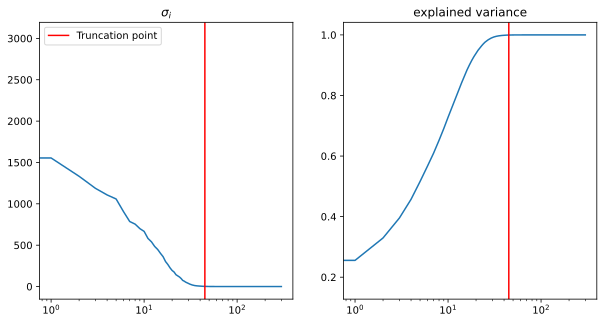

In [8]:
p = 45
Xi_N_p = Xi_N[:,0:p]

fig, axs = plt.subplots(1,2, figsize=(10,5))

axs[0].set_title(r"$\sigma_i$")
axs[0].semilogx(sigma_N)

axs[0].axvline(x=p, label="Truncation point", color="red")
axs[0].legend()

axs[1].set_title(r"explained variance")
axs[1].semilogx((np.cumsum(sigma_N) / np.sum(sigma_N)))


axs[1].axvline(x=p, label="Truncation point", color="red")

Here i use the DEIM algorihtm to find which points to sample

In [9]:
P = np.zeros((simulation_points,p))

arg_max = np.argmax(np.abs(Xi_N[:,0]))
P[arg_max,0] = 1

for j in range(1,p):
    c = np.linalg.solve(P[:,0:j].T @ Xi_N[:,0:j], P[:,0:j].T @ Xi_N[:,j])
    residual = Xi_N[:,j] - Xi_N[:,0:j] @ c
    arg_max = np.argmax(np.abs(residual))
    P[arg_max, j] = 1


Here I create the (L @ Psi) matrix:

In [10]:
d_Psi_hat = (1j*kappa[:,np.newaxis])*np.fft.fft(Psi, axis=0)
d_Psi = np.real(np.fft.ifft(d_Psi_hat, axis=0))

P_dPsi: The matrix $P^{T} D_x \Psi$ (a-coordinates -> real coordinates -> derivative -> sampled subspace) 

P_NL: The matrix (sampled subspace -> a-coordinates)

In [11]:
P_dPsi = P.T @ d_Psi
P_NL = Psi.T @ (Xi_N_p @ np.linalg.inv(P.T @ Xi_N_p))

In order to know if the model is unstable I plot the eigenvalues of $(P^T \Psi)^{-1}$. The results does land on a circle but the radius of this circle is above 1. I therefore fear that this simulation will at some point blow up if its kept running. I have had a hard time to generate a DEIM solution that didn't have high eigenvalues. It is only at very certain conditions that this method works for this problem.

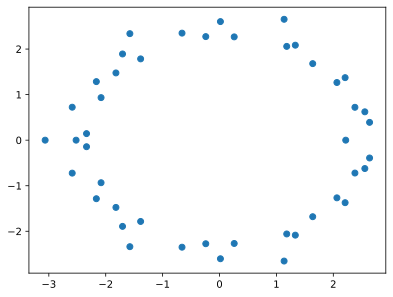

In [12]:
eig_inv = np.linalg.eigvals(np.linalg.inv(P.T @ Xi_N_p))
plt.scatter(np.real(eig_inv), np.imag(eig_inv))

The final model can be now be implemented

In [13]:
def rom_deim_rhs(t, a):
    du_approx = P_dPsi @ a
    return Psi_L @ a + P_NL @ (-(1/2)*(du_approx**2))

Now the system can be solved in "a"-coordinates which radically reduces the computations needed to simulate the system.

Solve time: 29.289804697036743


Text(0.5, 1.0, 'Difference MSE:0.0024')

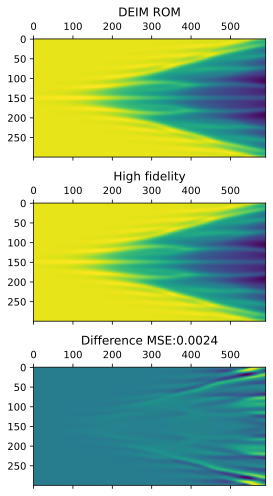

In [14]:
a0 = W[:,0]

t_deim_start = time.time()
sol_rom = scipy.integrate.solve_ivp(rom_deim_rhs, t_span=t_span, t_eval=t_simulation, y0=a0)
t_deim_stop = time.time()
y_deim = Psi @ sol_rom.y

mse_deim = np.mean((y_deim - y_simulation)**2)

print(f"Solve time: {t_deim_stop - t_deim_start}")

fig, axs = plt.subplots(3,1, figsize=(10,7))
fig.set_tight_layout(True)

axs[0].matshow((y_deim)[:,::200])
axs[0].set_title("DEIM ROM")

axs[1].matshow(y_simulation[:,::200])
axs[1].set_title("High fidelity")

axs[2].matshow((y_simulation-y_deim)[:,::200])
axs[2].set_title(f"Difference MSE:{mse_deim:.02}")

The above results show a good speedup and the error is not too bad. The conclusion is that the DEIM method can be used to significantly speed up simulation time for the KS system.

### POD-DMD

I will now use the POD-DMD method to do reduced order modeling. The method tries to predict the non-linear terms based on the current snapshot of the system.

Below I have plotted the sigmas and modes from the SVD of the non-linear terms. Here it can be seen that only a few terms contains the most variance of the system.

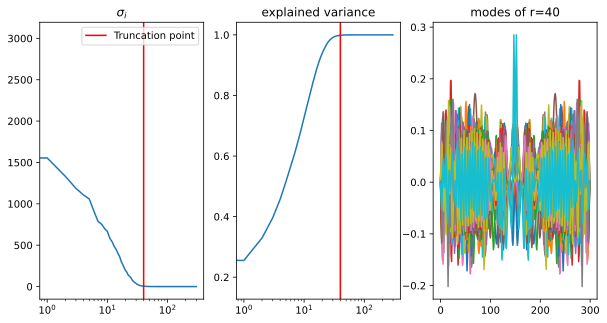

In [15]:
# From above Xi_N, sigma_N, Vt_N = SVD(N)

fig, axs = plt.subplots(1,3, figsize=(10,5))

axs[0].set_title(r"$\sigma_i$")
axs[0].semilogx(sigma_N)

axs[0].axvline(x=r, label="Truncation point", color="red")
axs[0].legend()

axs[1].set_title(r"explained variance")
axs[1].semilogx((np.cumsum(sigma_N) / np.sum(sigma_N)))


axs[1].axvline(x=r, label="Truncation point", color="red")

axs[2].set_title(f"modes of r={r}")
for i in range(r):
    axs[2].plot(Xi_N[:,i])


To model the linear terms i use the equation below:
$$N = A_N y$$

Here N is a matrix containing the non-linear terms in each column, Y is a matrix with each column containing a snapshot of the high fidelity solution. $A_n$ will be the linear DMD map that allows me to approximate the non-linear terms based on the current snapshot of the system.

I will be modeling the rhs in the $\Psi$-subspace. Therefore there is a bit of matrix algebra needed to project $A_N$ into the $\Phi$-subspace:

In [16]:
A_N =  N @ np.linalg.pinv(y_simulation)

P_A_N = Psi.T @ A_N @ Psi

In [17]:
def rom_dmd_rhs(t,a):
    return Psi_L @ a + P_A_N @ a

Solve time:20.663787126541138


Text(0.5, 1.0, 'Difference MSE:0.29')

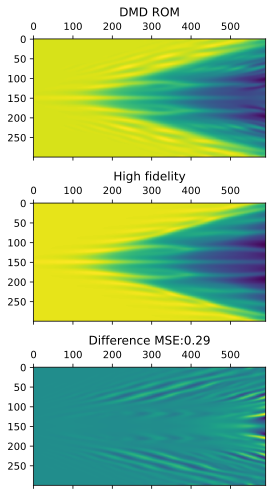

In [21]:
a0 = W[:,0]

t_dmd_start = time.time()
sol_dmd = scipy.integrate.solve_ivp(rom_dmd_rhs, y0=a0, t_span=(0,50), t_eval=t_simulation)
t_dmd_stop = time.time()

y_nl_dmd = Psi @ sol_dmd.y
mse_dmd = np.mean((y_nl_dmd - y_simulation)**2)

print(f"Solve time:{t_dmd_stop-t_dmd_start}")

fig, axs = plt.subplots(3,1, figsize=(10,7))
fig.set_tight_layout(True)

axs[0].matshow((y_nl_dmd)[:,::200])
axs[0].set_title("DMD ROM")

axs[1].matshow(y_simulation[:,::200])
axs[1].set_title("High fidelity")

axs[2].matshow((y_simulation-y_nl_dmd)[:,::200])
axs[2].set_title(f"Difference MSE:{mse_dmd:.02}")

The conclusion of this experiment is that POD-DMD can be used to do reduced order modeling. It turns out that this method is faster than DEIM but has a worse mean squared error.

### LSTM

**Idea**:
Predict the NL term from the previous x-number of states.

In [30]:
class LSTM_NL(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers, batch_first=True).double()
        self.nn = nn.Linear(hidden_size, input_size).double()

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        nn_output = self.nn(lstm_output[:, -1])
        return nn_output


In [68]:
from torch.utils.data import DataLoader

class CustomDatasetLSTM(Dataset):
    def __init__(self, num_layers):
        self.num_layers = num_layers
        self.X = torch.as_tensor((Psi.T @ y_simulation).T)

        self.factor =  self.X.max(axis=0)[0]
        self.X = self.X / self.factor

        self.Y = torch.as_tensor((Psi.T @ N).T)

    def __len__(self):
        return self.X.shape[0] - self.num_layers

    def __getitem__(self, idx):
        X = self.X[idx : (idx + self.num_layers)]
        y = self.Y[(idx + self.num_layers)]
        return X, y

I will try to predict the non-linear terms by using the 10 previous snapshots of the simulated model. Both the snapshots and non-linear terms will be in the reduced subspace of $\Psi$.

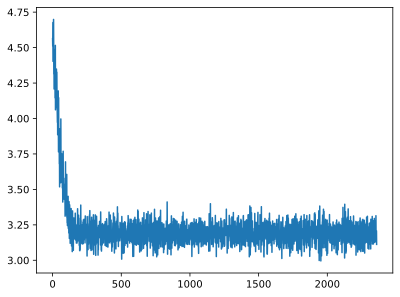

In [80]:
dataset = CustomDatasetLSTM(10)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

model = LSTM_NL(r,10,10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_losses = []
epochs = 20
for t in range(epochs):
    for batch in dataloader:
        X,y = batch
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_losses.append(float(loss))

plt.plot(train_losses)

To test the model I use a random sample from the dataset and try to predict 100 iterations forwards in time:

Text(0.5, 1.0, 'True non-linear terms')

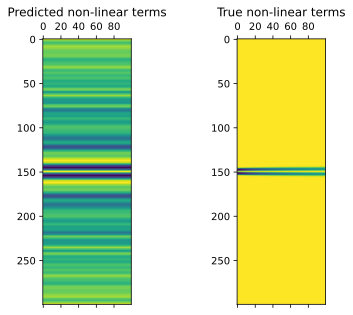

In [79]:
Xs,_ = dataset[0]

Ys_predicted = torch.zeros((100,40))

for i in range(100):
    new_point = model(Xs[None, -10:, :])
    Ys_predicted[i] = new_point

results = (Ys_predicted).T.detach().numpy()

fig,axs = plt.subplots(1,2)

axs[0].matshow(Psi @ results)
axs[0].set_title("Predicted non-linear terms")

axs[1].matshow(N[:,10:110])
axs[1].set_title("True non-linear terms")

Conclusion: The plot above clearly shows that the current LSTM model can not predict the non-linear terms. Since the model has only been trained on 20 epochs this is to be expected. This architecture might perform better with more training.